In [231]:
println("Loading libraries and data..")
using Pkg
using Revise
Pkg.activate("AlgebraicSolving.jl-main")
#import Nemo:
#    is_univariate,
#    coefficients_of_univariate
using AlgebraicSolving
using Nemo
#using Oscar
#include("tools.jl")
using BenchmarkTools
using IntervalArithmetic

Loading libraries and data..


  Activating project at `~/Documents/gittravail/AlgCurves/AlgebraicSolving.jl-main`


In [232]:
include("data.jl")
include("src/usolve/usolve.jl")
include("subresultants.jl")
#using Arblib

subresultants (generic function with 2 methods)

In [233]:
# Generic change of variables
changemat = [1 0; 0 1]
#changemat = rand(-100:100, 2, 2)
invchangemat = inv(changemat)
f = evaluate(f, collect(changemat*[x; y]));


In [234]:
sr = subresultants(f, derivative(f,y),2, list=true);

In [235]:
# Take the deg>0 sqfree factors of the resultant and order by multiplicity
# TODO : group by multiplicity
sqr = collect(factor_squarefree(sr[1][1]))
# Construct the parametrization of the critical points
params = [ [ q[1], -sr[2][1], sr[2][2] ] for q in sqr ];

In [236]:
function order_permut2d(L)
    # Create a list of tuples with elements and their corresponding indices
    LL = [(L[i][j], (i, j)) for i in eachindex(L) for j in eachindex(L[i])]
    # Sort the enumerated list based on the values
    sorted_LL = sort(LL, by = x -> x[1])
    # Extract the sorted values and their corresponding indices
    sorted_L = [pair[1] for pair in sorted_LL]
    sorted_ind = [pair[2] for pair in sorted_LL]
    
    return sorted_L, sorted_ind
end

function isolate(f; prec = 32, software="usolve")
    @assert is_univariate(f) "Not univariate polynomial"
	if software == "usolve"
		return usolve(f, precision = prec, uspath="src/usolve/usolve")
    end
end

function isolate_eval(f, ivar, val; prec=64)
    sols = inter_solutions(AlgebraicSolving.Ideal([f, gens(R)[ivar] - val]), precision=prec)
    return [ s[ivar%2+1] for s in sols ]
end

function Arb_to_rat(x)
	r = Nemo.radius(x)
	return map(simplest_rational_inside, [x-2*r, x+2*r])
end

function rat_to_Arb(x)
    x1,x2 = x
    xm, xd = RR((x1+x2)/2), RR(x2-x1)
    return ball(xm,xd)
end

function evaluate_Arb(f, x)
	cf = coefficients_of_univariate(f)
	return evalpoly(RR(x), cf) 
end

evaluate_Arb (generic function with 1 method)

In [274]:
precx = 150;

In [275]:
println("Isolating critical values..")
xcrit = [ isolate(first(p), prec=precx) for p in params ]
xcrit_usolve = getindex.(xcrit, 1)
xcrit = getindex.(xcrit, 2)
_, xcritpermut = order_permut2d(xcrit);

Isolating critical values..


In [276]:
println("Computing isolating critical boxes using Arb..")
#RR(x) = Arb(x, prec=120)
RR = ArbField(150)
Pcrit = [ [ [xc, evaluate_Arb(params[i][2], xc[1])/evaluate_Arb(params[i][3],xc[1])] for xc in xcrit[i]] for i in eachindex(xcrit) ]
LBcrit = [ [ [ map(QQ, pc[1]), map(QQ, Arb_to_rat(pc[2])) ]  for pc in pcrit] for pcrit in Pcrit ]
#Pcrit = [ [ [ rat_to_Arb(pc[1]), pc[2] ]  for pc in pcrit] for pcrit in Pcrit ];
print("")

Computing isolating critical boxes using Arb..


In [282]:
function in_inter(I, J)
    return J[1] < I[1] && I[2] < J[2]
end

function overlap_inter(I,J)
    return max(I[1], J[1]) <= min(I[2], J[2])
end

# To try/do : isolate with usolve, call msolve with only one variable
function intersect_box(f, B; prec=100)
    L = Array{Any}(undef, 4)
    for i in 1:2
        # Lxi
        L[i] = Array{Any}(undef,2)
        while true
            flag = false
            L[i][1] = isolate_eval(f, 2, B[2][i], prec=prec)
            L[i][2] = []
            for (j, l) in pairs(L[i][1])
                if in_inter(l, B[1])
                    push!(L[i][2], j)
                elseif overlap_inter(l, B[1])
                    prec *= 2
                    println("Increase precision to ", prec)
                    flag = true
                    break
                end
            end
            flag || break
        end
        # Lyi
        L[i+2] = Array{Any}(undef,2)
        while true
            flag = false
            L[i+2][1] = isolate_eval(f, 1, B[1][i], prec=prec)
            L[i+2][2] = []
            for (j, l) in pairs(L[i+2][1])
                if in_inter(l, B[2])
                    push!(L[i+2][2], j)
                elseif overlap_inter(l, B[2])
                    prec *= 2
                    println("Increase precision to ", prec)
                    flag = true
                    break
                end
            end
            flag || break
        end
    end
    return L
end

intersect_box (generic function with 2 methods)

In [283]:
function refine_xboxes(f, LB, prec)
    # Implementation of refine_xboxes function goes here
    xnew = isolate(f, prec=prec)[2]
    for i in eachindex(LB)
		  LB[i] = [ xnew[i], LB[i][2] ]
    end
end

refine_xboxes (generic function with 2 methods)

In [284]:
# Could be improved by handling nodes as extreme boxes:
# when npcside = [2,2,0,0] just take nearest below and above
# intersections b with the curves on the vertical sides
# and change into npcside = [0,0,2,2]
## TODO : Refine only the intervals that need to be refined
println("\nCompute intersections with critical boxes")
ts = time()
LPCside = Array{Any}(undef,length(LBcrit))
ndig = maximum([Int(floor(log10(length(LB)))) for LB in LBcrit])
Ltm = []
i = 1
while i <= length(LBcrit)
    ndigi = Int(floor(log10(length(LBcrit[i]))))
    LPCside[i] = Array{Any}(undef, length(LBcrit[i]))
    while true
        flag = false
        for j in eachindex(LBcrit[i])
            print("mult=$i ; $(j)/$(length(LBcrit[i]))$(repeat(" ", ndig-ndigi+1))pts","\r")
            tm = time()
            pcside = intersect_box(f, LBcrit[i][j], prec=precx)
            npcside = [length(n) for (I, n) in pcside]
            if i == 1 && sum(npcside) > 2
                precx *= 2
                println("\nRefine extreme boxes along x-axis")
                refine_xboxes(params[1][1], LBcrit[1], precx)
                #break
            elseif i > 1 && sum(npcside[1:2]) != 0
                precx *= 2
                println("\nRefine singular boxes along x-axis")
                refine_xboxes(params[2][1], LBcrit[2], precx)
                #refine_xboxes(QQ["x"](params[2][1]), LBcrit[2])
                #i -= 1
                #break
            end
            LPCside[i][j] = pcside
            push!(Ltm, time() - tm)
        end
        flag || break
    end
    i += 1
    println("")
end
LnPCside = [ [[length(indI) for (L, indI) in PB] for PB in lpcside] for lpcside in LPCside ] 
println("Average time for one point: $(sum(Ltm)/length(Ltm))s")
println("Elapsed time to compute critical boxes: $(time()-ts)s")



Compute intersections with critical boxes
Increase precision to 300
Increase precision to 300


InterruptException: InterruptException:

In [281]:
# Update extreme boxes
for j in eachindex(LBcrit[1])
    # If the curve does not intersect the box only on vertical sides
    if !(LnPCside[1][j][1:2] == [0, 0])
        PCside, nPCside = LPCside[1][j], LnPCside[1][j]
        I = [ l[1] for l in PCside[3:end] ]
        nI = [ l[2] for l in PCside[3:end] ]
        # Locate the orientation of the extreme point
        # s is the index on the side where there are more branches
        # s=1: left; s=2: right
        s = argmax([length(I[1]), length(I[2])])
        # Ordinate range of the extreme point
        ycrit = LBcrit[1][j][2]
        # If it intersects on the bottom side
        if nPCside[1] == 1
            # yinf: the intersection with the vertical side just below the extreme point
            yinf = maximum([i for (i, yy) in pairs(I[s]) if yy[1] < ycrit[2]])
            # We vertically enlarge the box until it intersects on the horizontal side
            push!(LPCside[1][j][s + 2][2], yinf)
            LPCside[1][j][1][2] = []
            # We update the intersection numbers
            LnPCside[1][j][s + 2] += 1
            LnPCside[1][j][1] = 0
        end
        # If it intersects on the top side
        if nPCside[2] == 1 
            # ymax: the intersection with the vertical side just above the extreme point
            ymax = minimum([i for (i, yy) in pairs(I[s]) if yy[2] > ycrit[1]])
            # We vertically enlarge the box until it intersects on the horizontal side
            push!(LPCside[1][j][s + 2][2], ymax)
            LPCside[1][j][2][2] = []
            # We update the intersection numbers
            LnPCside[1][j][s + 2] += 1
            LnPCside[1][j][2] = 0
        end
    end
end

UndefRefError: UndefRefError: access to undefined reference

In [244]:
print("Graph computation")
# Would be nice to have only one intermediate fiber (take the average of abscissa and ordinates) for plot
# And even remove this fiber for the graph
Vert = []
Edg = []
Corr = [[[[], [[], [], []], []] for j in xcrit[i] ] for i in eachindex(xcrit) ]
Viso = []
ite = 1

for ind in 1:length(xcritpermut)
    i, j = xcritpermut[ind]

    if ind > 1
        i1, j1 = xcritpermut[ind - 1]
    end
    if ind < length(xcritpermut)
        i2, j2 = xcritpermut[ind + 1]
        I2L, nI2L = LPCside[i2][j2][3]
    end

    PCside, nPCside = LPCside[i][j], LnPCside[i][j]
    I = [ l[1] for l in PCside[3:end] ]
    nI = [ l[2] for l in PCside[3:end] ]

    xcmid = sum(LBcrit[i][j][1])//2
    ycmid = sum(LBcrit[i][j][2])//2

    ymincrit = minimum(vcat(nI[1], nI[2], [length(I[1])+1]))
    # Construct vertices
    ###########################
    # On the vertical left side
    if ind > 1
        for k in 1:length(I[1])
            push!(Corr[i][j][1], Corr[i1][j1][3][k])
        end
    else
        for k in 1:length(I[1])
            push!(Vert, [xcrit[i][j][1], sum(I[1][k])//2])
            push!(Corr[i][j][1], ite)
            ite += 1
        end
    end
    ###########################
    # On the vertical right side
    if ind < length(xcritpermut)
        for k in 1:length(I[2])
            push!(Vert, [(xcrit[i][j][2] + xcrit[i2][j2][1])//2, sum(I[2][k] + I2L[k])//4])
            push!(Corr[i][j][3], ite)
            ite += 1
        end
    else
        for k in 1:length(I[2])
            push!(Vert, [xcrit[i][j][2], sum(I[2][k])//2])
            push!(Corr[i][j][3], ite)
            ite += 1
        end
    end
    ###########################
    # Below the critical point
    #println()
    #println(map(length,I))
    #println(vcat(nI[1], nI[2], [length(I[1])+1]))
    for k in 1:ymincrit-1
        push!(Vert, [xcmid, sum(I[1][k] + I[2][k])// 4])
        push!(Corr[i][j][2][1], ite)
        push!(Edg, [Corr[i][j][1][k], ite])  # left
        push!(Edg, [ite, Corr[i][j][3][k]])  # right
        ite += 1
    end
    ###########################
    # The critical point
    ##########################
    # if it is an isolated point
    if isempty(nI[1]) && isempty(nI[2])
        #pass
        # We can add the isolated  vertex
        # push!(Vert, Pcrit[i][j])
        # push!(Corr[i][j][2][1], ite)
        # We will subsequently add the vertex in the graph
        # push!(Viso, ite)
        # ite += 1
    ############################################
    ## TO BE REPLACED BY APPSING IDENTIFICATOR ##
    ## works for space curves without nodes   ##
    ############################################
    # If we are dealing with a node
    elseif i == 2
        # We connect the pairwise opposite branches nI[1][1][i] and nI[1][2][i+1 mod 2], i=1,2
        push!(Edg, [Corr[i][j][1][nI[1][1]], Corr[i][j][3][nI[2][2]]])
        push!(Edg, [Corr[i][j][1][nI[1][2]], Corr[i][j][3][nI[2][1]]])
    else
        # We can add the vertex
        push!(Vert, [xcmid, ycmid])
        push!(Corr[i][j][2][2], ite)
        # We connect to the vertical left side of the critical box
        for k in nI[1]
            push!(Edg, [Corr[i][j][1][k], ite])
        end
        # We connect to the vertical right side of the critical box
        for k in nI[2]
            push!(Edg, [ite, Corr[i][j][3][k]])
        end
        ite += 1
    end
    ###########################
    # Above the critical point
    for k=(length(I[1]) - length(nI[1]) - ymincrit+1):-1:1
        push!(Vert, [xcmid, sum(I[1][end - k + 1] + I[2][end - k + 1])//4])
        push!(Corr[i][j][2][3], ite)
        push!(Edg, [Corr[i][j][1][end - k + 1], ite])  # left
        push!(Edg, [ite, Corr[i][j][3][end - k + 1]])  # right
        ite += 1
    end
end

Graph computation

UndefRefError: UndefRefError: access to undefined reference

In [245]:
using Plots,Colors

In [246]:

function plot_graph(V, E)
    println("Plotting the graph")
    plot(legend=false)
    for e in E
        xe, ye = map(Float64,[e[1][1], e[2][1]]), map(Float64,[e[1][2], e[2][2]])
        plot!(xe, ye, lc="red", lw=3)
    end
    scatter!( map(Float64, [v[1] for v in V]),  map(Float64, [v[2] for v in V]), mc="black", m=:diamond)
    #plt.show(block=true)
    plot!()
end

plot_graph (generic function with 1 method)

Plotting the graph


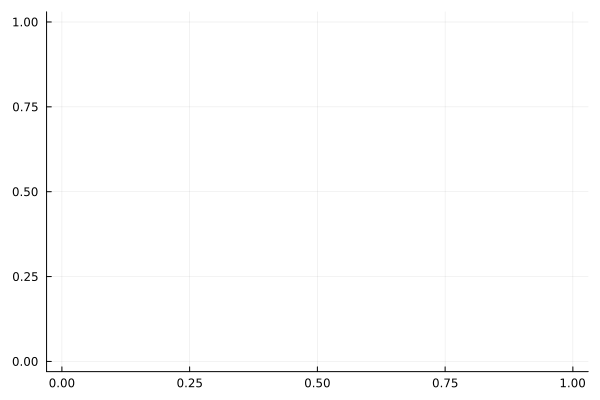

In [247]:
EdgPlot = [[Vert[k] for k in [i, j]] for (i, j) in Edg]
plot_graph(Vert, EdgPlot)

In [248]:
function connected_components_bis(edges)
    adj_list = Dict{Int, Vector{Int}}()
    visited = Set{Int}()
    components = Vector{Vector{Tuple{Int, Int}}}()

    # Build adjacency list
    for (i, j) in edges
        push!(get!(adj_list, i, []), j)
        push!(get!(adj_list, j, []), i)
    end

    
    # Depth-first search
    function dfs(node, component)
        push!(visited, node)
        for neighbor in adj_list[node]
            if !(neighbor in visited)
                push!(component, (node, neighbor))
                dfs(neighbor, component)
            end
        end
    end
    

    # Breadth-first search
    function bfs(node, component)
        queue = [node]
        push!(visited, node)
        while !isempty(queue)
            current = popfirst!(queue)
            for neighbor in adj_list[current]
                if !(neighbor in visited)
                    push!(visited, neighbor)
                    push!(component, (current, neighbor))
                    push!(queue, neighbor)
                end
            end
        end
    end

    # Find connected components
    for node in keys(adj_list)
        if !(node in visited)
            component = Vector{Tuple{Int, Int}}()
            bfs(node, component)
            push!(components, component)
        end
    end

    return components
end


connected_components_bis (generic function with 1 method)

In [249]:
CEdg = connected_components_bis(Edg); println(length(CEdg))

0


In [250]:
function plot_graph_comp(V, CE)
    println("Plotting the graph")
    plot(legend=false)
    col = distinguishable_colors(length(CE)+2)
    for j in eachindex(CE)
        for e in CE[j]
            v1, v2 = map(Float64, V[e[1]]), map(Float64, V[e[2]])
            plot!([v1[1], v2[1]], [v1[2], v2[2]], lc=col[j+2], lw=3)
        end
    end
    #plt.show(block=true)
    plot!()
end

plot_graph_comp (generic function with 1 method)

Plotting the graph


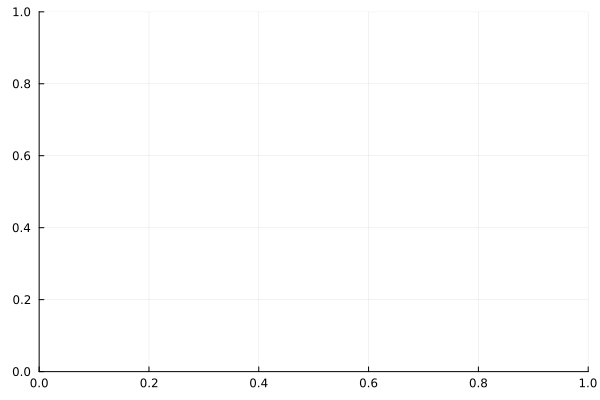

In [251]:
plot_graph_comp(Vert,CEdg)